## Bike Sharing Demand

#### Kaggle 競賽連結 https://www.kaggle.com/c/bike-sharing-demand

In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sampleSubmission.csv')

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.info() #info() 看資料有沒有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 978.1+ KB


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 431.2+ KB


In [9]:
train.describe()
# 這裡的count 是 label，其他columns是 feature

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Feature Engineering
### 大略看資料分布

In [10]:
# 對每個column來判斷最大值是否是離群值
train_describe = train.describe()
train_describe.head()
train_describe.loc['max'] > (train_describe.loc['mean']+3*train_describe.loc['std'])


season        False
holiday        True
workingday    False
weather        True
temp          False
atemp         False
humidity      False
windspeed      True
casual         True
registered     True
count          True
dtype: bool

In [11]:
#remove outlier(以count 來計算，移除超過平均值3倍sigma的rows)
# 這裡做的是，把label值中，明顯偏差過大的值除去，避免對Model造成影響
print('Shape of the Before Outliers:',train.shape)
train = train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())]
print('Shape of the After Outliers:',train.shape)

Shape of the Before Outliers: (10886, 12)
Shape of the After Outliers: (10739, 12)


### 初步資料處理

In [12]:
# 先把Train, Test Data合併後一起處理時間部分，將其數字化為可以丟進Model的形式
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)
data.head()

c:\users\sean\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


In [13]:
# 將時間處理成讓Random forest可以分析的格式

data['date'] = data.datetime.apply(lambda x : x.split()[0])
data['hour'] = data.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')
data['year'] = data.datetime.apply(lambda x : x.split()[0].split('-')[0])
data['weekday'] = data.date.apply(lambda dataString : datetime.strptime(dataString, "%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,0,2011,5,1
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,1,2011,5,1
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011-01-01,2,2011,5,1
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011-01-01,3,2011,5,1
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011-01-01,4,2011,5,1


### 觀察Feature，並針對有問題的資料作調整

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, 'distribution of windspeed')]

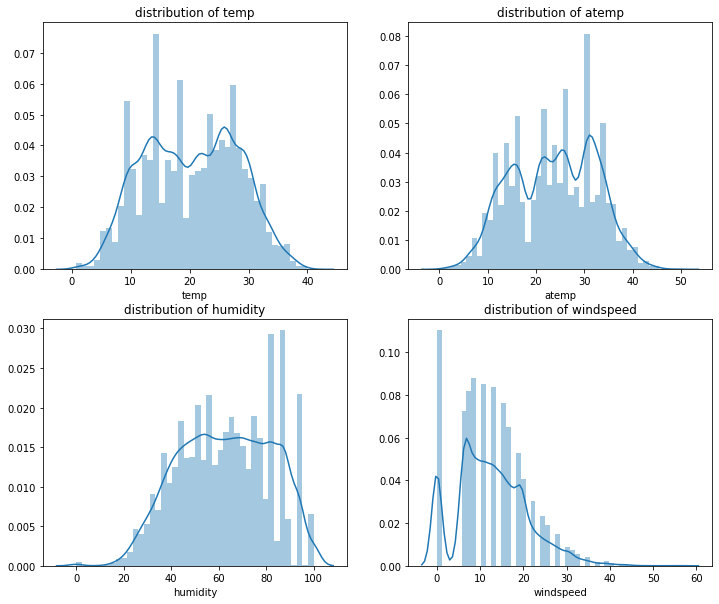

In [14]:

fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)
sns.distplot(data['temp'], ax=axes[0][0])
sns.distplot(data['atemp'], ax=axes[0][1])
sns.distplot(data['humidity'], ax=axes[1][0])
sns.distplot(data['windspeed'], ax=axes[1][1])

axes[0][0].set(xlabel='temp', title='distribution of temp')
axes[0][1].set(xlabel='atemp',title="distribution of atemp")
axes[1][0].set(xlabel='humidity',title="distribution of humidity")
axes[1][1].set(xlabel='windspeed',title="distribution of windspeed")
# axes[1][1].set(xlim=(0,10),xlabel='windspeed',title="distribution of windspeed")

#這邊觀察到風速為0的值異常的多，風速2~5則沒有值，推測可能太小的值機器量測不到，系統會認定為0

In [15]:
#我們先將資料分成風速為0以及風速不為0的資料，並且用風速不為0的資料來訓練random forest的模型，將訓練好的模型來預估風速為0的風速到底是多少。
dataWind0 = data[data.windspeed==0]
dataWindNot0 = data[data.windspeed!=0]

rfModel_wind = RandomForestRegressor(n_estimators=1000, random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0.windspeed)

wind0Values = rfModel_wind.predict(dataWind0[windColumns])
dataWind0.loc[:,'windspeed'] = wind0Values

data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.head(15)

c:\users\sean\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,12.880,0.0,1.0,2011-01-01 05:00:00,0,75,1.0,1,9.84,2,6.0032,0,2011-01-01,5,2011,5,1
1,19.695,12.0,36.0,2011-01-01 10:00:00,0,76,24.0,1,15.58,1,16.9979,0,2011-01-01,10,2011,5,1
2,16.665,26.0,56.0,2011-01-01 11:00:00,0,81,30.0,1,14.76,1,19.0012,0,2011-01-01,11,2011,5,1
3,21.210,29.0,84.0,2011-01-01 12:00:00,0,77,55.0,1,17.22,1,19.0012,0,2011-01-01,12,2011,5,1
4,22.725,47.0,94.0,2011-01-01 13:00:00,0,72,47.0,1,18.86,2,19.9995,0,2011-01-01,13,2011,5,1
5,22.725,35.0,106.0,2011-01-01 14:00:00,0,72,71.0,1,18.86,2,19.0012,0,2011-01-01,14,2011,5,1
6,21.970,40.0,110.0,2011-01-01 15:00:00,0,77,70.0,1,18.04,2,19.9995,0,2011-01-01,15,2011,5,1
7,21.210,41.0,93.0,2011-01-01 16:00:00,0,82,52.0,1,17.22,2,19.9995,0,2011-01-01,16,2011,5,1
8,21.970,15.0,67.0,2011-01-01 17:00:00,0,82,52.0,1,18.04,2,19.0012,0,2011-01-01,17,2011,5,1
9,21.210,9.0,35.0,2011-01-01 18:00:00,0,88,26.0,1,17.22,3,16.9979,0,2011-01-01,18,2011,5,1


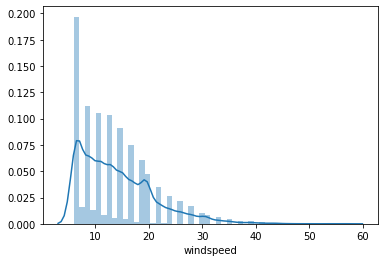

In [17]:
sns.distplot(data.windspeed)
#調整風速資料的結果如下

### 觀察Label，並調整

In [23]:
#先把data分解成原本的兩組資料，並刪除不需要的columns
dataTrain = data[~data['count'].isnull()].sort_values(by='datetime')
dataTest = data[data['count'].isnull()].sort_values(by='datetime')
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]

dropFeatures = ['casual',"count","datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
dataTrain.head(15)

,atemp,holiday,humidity,season,temp,weather,windspeed,workingday,hour,year,weekday,month
15068,14.395,0,81,1,9.84,1,6.999983,0,0,2011,5,1
15069,13.635,0,80,1,9.02,1,6.747321,0,1,2011,5,1
15070,13.635,0,80,1,9.02,1,6.747321,0,2,2011,5,1
15071,14.395,0,75,1,9.84,1,6.688371,0,3,2011,5,1
15072,14.395,0,75,1,9.84,1,6.688371,0,4,2011,5,1
0,12.880,0,75,1,9.84,2,6.003200,0,5,2011,5,1
15073,13.635,0,80,1,9.02,1,6.747321,0,6,2011,5,1
15074,12.880,0,86,1,8.20,1,6.779684,0,7,2011,5,1
15075,14.395,0,75,1,9.84,1,6.688371,0,8,2011,5,1
15076,17.425,0,76,1,13.12,1,9.124935,0,9,2011,5,1


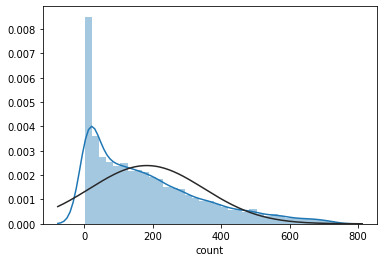

In [19]:
from scipy.stats import * #要先import，才能使用下面fit 參數的功能
sns.distplot(yLabels, fit=norm) #[問題]這個fit怎麼畫出來的，還不太清楚

#可看到Label分布，距離理想的常態分佈還有一段距離，對整組資料取log做調整 
        # [問題]為什麼可以這樣搞label? 這樣不會破壞資料真實度? 還是說，在某個校正範圍內是可被允許的

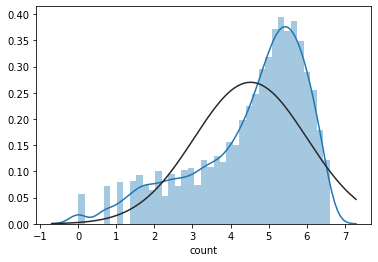

In [20]:
yLabelLog = np.log(yLabels)
sns.distplot(yLabelLog, fit=norm)

## Modeling and Predict

In [21]:
rfModel = RandomForestRegressor(n_estimators=100, random_state=42)
rfModel.fit(dataTrain, yLabelLog)
preds = rfModel.predict(dataTest)

preds

array([2.4162119 , 1.65324576, 1.12415194, ..., 4.98824716, 4.70277445,
       4.07077886])

In [24]:
predsTest = rfModel.predict(X= dataTest)
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_RF.csv', index=False)